## Leitura dos arquivos de dados - arquivo em binário

Os dados com que trabalharemos para análise estão em formato binário. Neste primeiro momento, iremos ter apenas dados de duas RPCs, todo evento tendo sinal em apenas uma. Dessa forma, cada evento consiste de 2 bytes, o primeiro contendo o número da pad da RPC inferior que detectou sinal e o segundo o número da pad da RPC superior, dessa forma tendo arquivos 65 vezes menores que os arquivos em formato .txt (onde cada linha ocupa 130 bytes no arquivo).

In [19]:
blacklist_RPC_1=[]
blacklist_RPC_2=[]

In [22]:
import numpy as np

def getNpads_1(nome_arquivo='EAFEXP_2024_01_28.bin'):
    binario=open('EAFEXP_2024_01_28.bin', 'rb')   #lê o arqmyfile.binuivo binário
    nPads_RPC1, nPads_RPC2 = [], []    #cria os arrays de n de pads
    array = np.fromfile(binario, dtype=np.uint8) #array para o qual os bytes do arquivo serão lidos
    tamanho=len(array) #tamanho do array lido
    indice=0 #indice usado para varrer o array
    while(indice<tamanho):     # converte de uint8_t para int comum e separa as pads de cada RPC em um array diferente
        nPads_RPC1.append(int(array[indice]))
        nPads_RPC2.append(int(array[indice+1]))
        indice+=2
    return nPads_RPC1, nPads_RPC2

getNpads_1()

([42,
  33,
  11,
  43,
  22,
  35,
  48,
  31,
  48,
  56,
  34,
  47,
  17,
  63,
  45,
  38,
  63,
  43,
  26,
  9,
  55,
  64,
  32,
  54,
  30,
  44,
  27,
  31,
  8,
  12,
  48,
  4,
  33,
  11,
  44,
  12,
  8,
  16,
  48,
  12,
  10,
  37,
  4,
  33,
  25,
  12,
  2,
  47,
  63,
  60,
  37,
  35,
  34,
  38,
  30,
  27,
  35,
  49,
  14,
  30,
  38,
  4,
  27,
  56,
  49,
  57,
  54,
  1,
  2,
  12,
  52,
  52,
  9,
  53,
  5,
  30,
  1,
  54,
  11,
  49,
  63,
  35,
  4,
  39,
  60,
  34,
  45,
  23,
  4,
  35,
  61,
  27,
  14,
  37,
  63,
  64,
  63,
  15,
  19,
  43,
  3,
  6,
  22,
  63,
  56,
  61,
  32,
  7,
  32,
  25,
  47,
  11,
  38,
  62,
  47,
  60,
  27,
  18,
  43,
  44,
  56,
  21,
  16,
  30,
  24,
  6,
  63,
  7,
  5,
  52,
  12,
  64,
  24,
  49,
  14,
  51,
  43,
  11,
  54,
  64,
  42,
  10,
  31,
  61,
  15,
  31,
  13,
  58,
  29,
  60,
  16,
  14,
  54,
  60,
  27,
  45,
  37,
  36,
  51,
  51,
  16,
  4,
  36,
  38,
  40,
  35,
  38,
  63,
  51,
  58,
 

## Determinação das trajetórias

Agora que sabemos identificar o número das *pads* onde houve detecção, precisamos entender como fazer a correspondência entre os números das *pads* e as coordenadas espaciais, isto é, as **posições** por onde passaram os múons. Evidentemente, a posição em termos absolutos depende de adotarmos um referencial. No entanto, veremos que a posição absoluta não nos interessa; estaremos mais interessados na **posição relativa** entre as *pads* sensibilizadas das RPC de cima e de baixo para cada evento. De todo modo, isto requer um conhecimento prévio de outras informações, como a numeração e disposição das *pads* ao longo das RPCs e seus tamanhos.

As RPCs estão numeradas igualmente de acordo com a seguinte mapa 2D em forma de matriz (vista da RPC por cima):

```python 
disposicao das pads =[
    [8, 16, 24, 32, 40, 48, 56, 64], #todos os numeros desta linha sao multiplos de 8
    [7, 15, 23, 31, 39, 47, 55, 63], 
    [6, 14, 22, 30, 38, 46, 54, 62],
    [5, 13, 21, 29, 37, 45, 53, 61], 
    [4, 12, 20, 28, 36, 44, 52, 60],
    [3, 11, 19, 27, 35, 43, 51, 59],
    [2, 10, 18, 26, 34, 42, 50, 58],
    [1,  9, 17, 25, 33, 41, 49, 57]]
    numero da pad = i*8 + j
```

Por conveniência, admitiremos que as RPCs estão dispostas horizontalmente no plano xy e espaçadas verticalmente no eixo z, com eixo x indo da esquerda pra direita, eixo y de baixo pra cima, e z saindo da tela. Observe que, como as *pads* possuem tamanho fixo, a distância (em um dos eixos x ou y) entre *pads* corresponde sempre a um **múltiplo do tamanho da *pad*** nessa direção; ou seja, se as *pads* possuem 15 cm de tamanho ao longo do eixo x, a distância no eixo x entre os centros das pads 1 e 9 é de 15 cm; entre as pads 1 e 17 é 30 cm, e assim por diante. De maneira análoga, se o tamanho das *pads* no eixo y é de 19 cm, a distância no eixo y entre as *pads* 1 e 2 é de 19 cm; entre as pads 1 e 3 é de 38 cm, e assim por diante. 

Observe que a distância no eixo x depende então das **colunas** correspondentes às *pads* e a distância no eixo y das **linhas**, de acordo com a disposição 2D apresentada. Podemos então generalizar essa relação através das expressões a seguir, onde convencionamos `Lx=15cm` o tamanho das *pads* no eixo x, `Ly=19cm` o tamanho das *pads* no eixo y, e consideramos a distância entre duas *pads* denotada por $\delta X$ e $\delta Y$, nos eixos x e y respectivamente: 

$$
\delta X = (coluna_{pad_1} - coluna_{pad_2})\times L_x \\
\delta Y = (linha_{pad_1} - linha_{pad_2})\times L_y
$$

Precisamos, então, converter o número da *pad* na linha e coluna correspondente do mapa 2D de numeração. Isso pode ser feito de diferentes maneiras, observando que cada coluna abriga oito linhas. Veja, por exemplo, a função getLineAndCol() abaixo.


In [23]:
def getLineAndCol(Npad):
    line, col = Npad, 1
    while(line > 8):
        line = line - 8
    while(Npad > 8):
        Npad = Npad - 8
        col = col + 1

    return line, col   

Teste rodar a função `getLineAndCol()` com diferentes valores de Npad e compare com o que você esperava ao olhar o mapa de disposição 2D da numeração das *pads*. Os resultados fazem sentido?

In [24]:
getLineAndCol(64)

(8, 8)

De posse do número da linha e da coluna correspondentes, podemos então calcular as distâncias nos eixos x e y, `deltaX` e `deltaY`, conforme definimos anteriormente. Com os valores de `deltaX`, de `deltaY` e da distância entre as RPCs, que denotaremos por `H`, poderemos então calcular outras duas informações: os ângulos **azimutal** e **zenital**. Para isto, precisamos considerar a geometria da trajetória, conforme ilustrado na figura a seguir:

![coordenadas](coordenadas.png)

Podemos definir, portanto, as funções `getDeltaX()`, `getDeltaY()`, `getZen()` e `getAzi()` conforme feito a seguir: 

In [25]:
from math import sqrt, atan, asin, pi

Lx = 15 #cm
Ly = 19 #cm
H = 202.6 #cm

def getDeltaX(col_pad1, col_pad2):
    return (col_pad1 - col_pad2)*Lx

def getDeltaY(lin_pad1, lin_pad2):
    return (lin_pad1 - lin_pad2)*Ly

def getZen(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    return (180 * atan(diag / H)/pi)

def getAzi(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    azi = asin(deltaY/diag)
    if (deltaX) <= 0.:
        azi = pi - azi
    if azi < 0 and (deltaX) > 0.:
        azi = 2*pi + azi
    return 180*azi/pi

Podemos então chamar estas funções em conjunto para calcular os ângulos zenital e azimutal, dando como input apenas os índices das *pads* onde houve detecção, como feito na função `calcAngles()` a seguir:

In [26]:
def calcAngles(Npad1, Npad2):
    lin_pad1, col_pad1 = getLineAndCol(Npad1)
    lin_pad2, col_pad2 = getLineAndCol(Npad2)

    deltaX = getDeltaX(col_pad1, col_pad2)
    deltaY = getDeltaY(lin_pad1, lin_pad2)

    zen = getZen(deltaX, deltaY)
    azi = getAzi(deltaX, deltaY)
    
    return azi, zen

Experimente brincar com os índices das *pads* e rodar a função:

In [27]:
calcAngles(2, 14)

(258.83511982245136, 20.924851053461005)

## O output: visualizando nossos resultados

Finalmente, podemos juntar tudo que fizemos até aqui para analisar um arquivo de dados real. 
Precisamos apenas aprender a organizar nossos resultados de modo que possamos visualizá-los, analisá-los e apresentá-los a nossos pares na comunidade acadêmica. Para isso, vamos utilizar as bibliotecas `matplotlib` e `numpy`.

Observe o código abaixo:

In [30]:
from math import sqrt, atan, asin, log10, pi
from matplotlib import pyplot as plt
import numpy as np 

Lx = 15 #cm
Ly = 19 #cm
H = 202.6 #cm

def getNpads(nome_arquivo='EAFEXP_2024_01_28.bin'):
    binario=open('EAFEXP_2024_01_28.bin', 'rb')   #lê o arqmyfile.binuivo binário
    nPads_RPC1, nPads_RPC2 = [], []    #cria os arrays de n de pads
    array = np.fromfile(binario, dtype=np.uint8) #array para o qual os bytes do arquivo serão lidos
    tamanho=len(array) #tamanho do array lido
    indice=0 #indice usado para varrer o array
    while(indice<tamanho):     # converte de uint8_t para int comum e separa as pads de cada RPC em um array diferente
        nPads_RPC1.append(int(array[indice]))
        nPads_RPC2.append(int(array[indice+1]))
        indice+=2
    return nPads_RPC1, nPads_RPC2

getNpads()

def getLineAndCol(Npad):
    line, col = Npad, 1
    while(line > 8):
        line = line - 8
    while(Npad > 8):
        Npad = Npad - 8
        col = col + 1

    return line, col   

def getDeltaX(col_pad1, col_pad2):
    return (col_pad1 - col_pad2)*Lx

def getDeltaY(lin_pad1, lin_pad2):
    return (lin_pad1 - lin_pad2)*Ly

def getZen(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    return (180 * atan(diag / H)/pi)

def getAzi(deltaX, deltaY):
    diag = sqrt(deltaX*deltaX + deltaY*deltaY)
    if(diag > 0):
        azi = asin(deltaY/diag)
        if (deltaX) <= 0.:
            azi = pi - azi
        if azi < 0 and (deltaX) > 0.:
            azi = 2*pi + azi
        return 180*azi/pi
    else:
        return 0

def calcAngles(Npad1, Npad2):
    lin_pad1, col_pad1 = getLineAndCol(Npad1)
    lin_pad2, col_pad2 = getLineAndCol(Npad2)

    deltaX = getDeltaX(col_pad1, col_pad2)
    deltaY = getDeltaY(lin_pad1, lin_pad2)

    zen = getZen(deltaX, deltaY)
    azi = getAzi(deltaX, deltaY)
    
    return azi, zen



Vamos usar as funções definidas para ler e analisar o arquivo de dados `sem_chumbov1.txt`:

In [31]:
# from ROOT import TH2D, TCanvas

nPads_RPC1, nPads_RPC2 = getNpads('EAFEXP_2024_01_28.bin')
azimutal, zenital = [], []
line_RPC1, col_RPC1 = [], []
line_RPC2, col_RPC2 = [], []

# h2_top = TH2D("h2_top", "", 8, 0.5, 8.5, 8, 0.5, 8.5)

for i in range(len(nPads_RPC1)):
    azi, zen = calcAngles(nPads_RPC1[i], nPads_RPC2[i])
    azimutal.append(azi)
    zenital.append(zen)
    
    line1, col1 = getLineAndCol(nPads_RPC1[i])
    line2, col2 = getLineAndCol(nPads_RPC2[i])
    line_RPC1.append(line1)
    line_RPC2.append(line2)
    col_RPC1.append(col1)
    col_RPC2.append(col2)

    # h2_top.Fill(col1, line1)
    
    
Npads_1, Npads_2 = np.array(nPads_RPC1), np.array(nPads_RPC2)
Azimute, Zenite = np.array(azimutal), np.array(zenital)

Agora, podemos produzir *plots* das distribuições de contagens em função do número da *pad* em cada uma das RPCs de maneira bastante simples:

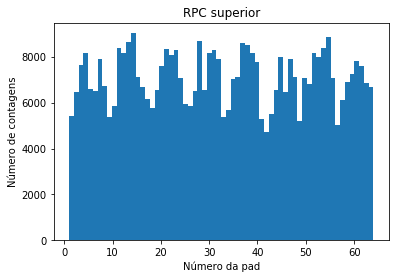

In [33]:
plt.hist(Npads_1, bins=64)
plt.ylabel("Número de contagens")
plt.xlabel("Número da pad")
plt.title("RPC superior")
plt.show()

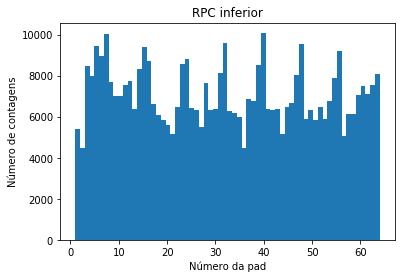

In [34]:
plt.hist(Npads_2, bins=64)
plt.ylabel("Número de contagens")
plt.xlabel("Número da pad")
plt.title("RPC inferior")
plt.show()

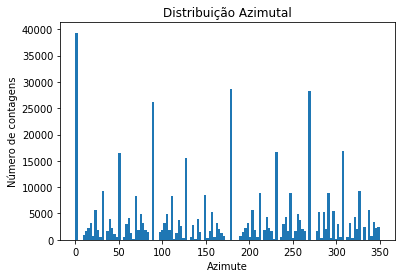

In [42]:
plt.hist(Azimute, bins=128)
plt.ylabel("Número de contagens")
plt.xlabel("Azimute")
plt.title("Distribuição Azimutal")
plt.show()

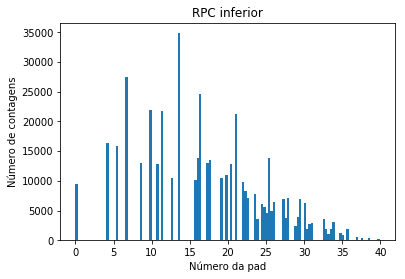

In [41]:
plt.hist(Zenite, bins=128)
plt.ylabel("Número de contagens")
plt.xlabel("Zênite")
plt.title("Distribuição Azimutal")
plt.show()

Podemos ver ainda a distribuição de eventos em 2D ao longo da RPC, como quem vê a RPC de cima. Nesse caso teremos um mapa de cores, indicado no eixo z, com o número de contagens em cada pad. Para os *plots* abaixo, uma cor mais clara indica menos eventos, enquanto uma cor mais vermelha e escura indica mais eventos, de 0 a 20000. 

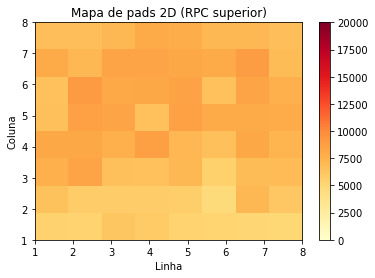

In [35]:
plt.hist2d(col_RPC1, line_RPC1, bins=[8,8], cmap="YlOrRd", vmin=0, vmax=20000)
plt.colorbar()
plt.ylabel("Coluna")
plt.xlabel("Linha")
plt.title("Mapa de pads 2D (RPC superior)")
plt.show()

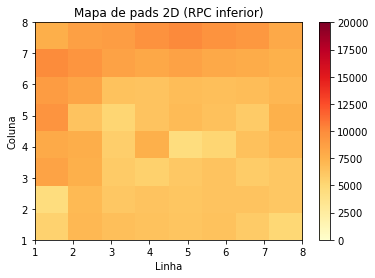

In [36]:
plt.hist2d(col_RPC2, line_RPC2, bins=[8,8], cmap="YlOrRd", vmin=0, vmax=20000)
plt.colorbar()
plt.ylabel("Coluna")
plt.xlabel("Linha")
plt.title("Mapa de pads 2D (RPC inferior)")
plt.show()

Vamos agora ver as distribuições em função dos ângulos azimutal e zenital. O que você espera da aparência dessas distribuições?

In [ ]:
plt.hist(Azimute, bins=180, histtype='stepfilled')
plt.ylabel("Número de contagens")
plt.xlabel("Angulo azimutal")
plt.title("Distribuicao angular (azimutal)")
plt.show()

In [ ]:
plt.hist(Zenite, bins=90)
plt.ylabel("Número de contagens")
plt.xlabel("Angulo zenital")
plt.title("Distribuicao angular (zenital)")
plt.show()

## Eficiência geométrica revisitada
Vamos agora usar simulação para determinar a eficiência geométrica das diferentes pads das RPC superior, levando em conta as pads inutilizadas da RPC inferior. Para isso, criaremos, à mão, duas blacklists de pads defeituosas nos arrays abaixo:



In [50]:
from math import sqrt, atan, asin, log10, pi, cos, sin, tan
from matplotlib import pyplot as plt
import numpy as np

Lx = 15 #cm
Ly = 19 #cm
H = 202.6 #cm

def getLineAndCol(Npad):
    line, col = Npad, 1
    while(line > 8):
        line = line - 8
    while(Npad > 8):
        Npad = Npad - 8
        col = col + 1
    return line, col  

def getNpad(x,y):
    line=int(y/Ly)+1
    col=int(x/Lx)+1
    return (col-1)*8+line
    
def sortTopPos(Npad):
    line,col=getLineAndCol(Npad)
    x0=(col-1)*Lx
    y0=(line-1)*Ly
    xsort=x0+np.random.rand()*Lx
    ysort=y0+np.random.rand()*Ly
    return xsort,ysort

def IsInsideRPC(x, y):
    return ((0.< x <= 8*Lx) and (0.<= y <= 8*Ly))

def isValid(Npad,RPC):
    if(RPC==1):
        for i in blacklist_RPC_1:
            if (Npad==i):
                return False
        return True
    else:
        for i in blacklist_RPC_2:
            if (Npad==i):
                return False
        return True

def calcPosInf(x_sup,y_sup,zen,azi,H):
        zen_tan=tan(zen)   
        slopex=cos(azi)*zen_tan
        slopey=sin(azi)*zen_tan
        x_inf=x_sup+slopex*H
        y_inf=y_sup+slopey*H
        return x_inf,y_inf
    
def sortcos2():
    while True:
        x=np.random.rand()*(pi/2.) #zenite indo de 0 até 90°
        y=np.random.rand()
        fx=cos(x)**2
        if(y<fx):
            return x

def simulation(Nevts, Npad1_list, zen_list, azi_list):
    
    eff_list = []
    for Npad_sup in range(1,65):
        Nhits = 0
        for ievt in range(0,Nevts):
            x_sup,y_sup=sortTopPos(Npad_sup)
            zen = sortcos2()
            azi = np.random.rand()*2*pi
            x_inf, y_inf = calcPosInf(x_sup,y_sup,zen,azi,H)
            if (IsInsideRPC(x_inf,y_inf)):
                Npad_inf=getNpad(x_inf,y_inf)
                if(isValid(Npad_inf,2)):   
                    Npad1_list.append(Npad_sup)
                    zen_list.append(zen)
                    azi_list.append(azi)
                    Nhits = Nhits + 1
        eff_list.append(Nhits/Nevts)
        
    return eff_list

Vamos usar a função `simulation()` com 100000 eventos para obter uma lista com as eficiências para cada uma das pads:

In [51]:
Nevts = 100000
Npad1_list, zen_list, azi_list = [], [], []
eff_list = simulation(Nevts, Npad1_list, zen_list, azi_list)
Npads_1 = np.array(Npad1_list)
Azimute, Zenite = np.array(azi_list), np.array(zen_list)

Podemos fazer um gráfico da eficiência em função da pad:

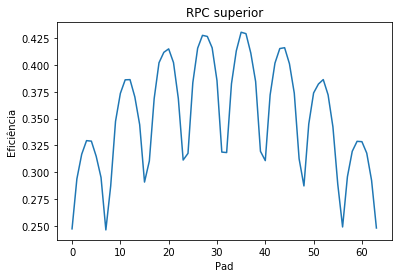

In [52]:
plt.plot(eff_list)
plt.ylabel("Eficiência")
plt.xlabel("Pad")
plt.title("RPC superior")
plt.show()

Responda: a distribuição da eficiência tem o formato que você esperava? Por quê?

### Fluxo de múons

Agora que determinamos a eficiência e temos o número de eventos observados, ambos em função das pads da RPC, podemos obter o fluxo de múons em cada pad! O fluxo $F_i$, onde $i$ é um indice referente à pad da RPC ($i=1,...,64$), é dado pela expressão:

$$
F_i = \frac{N_{obs}^{i}}{A\times \Delta t\times \varepsilon_{geom.}^{i}\times \varepsilon_{det.}^{i}}
$$

Na expressão acima, para cada pad, $A=L_x \times L_y$ é a área, $\Delta t$ o tempo de coleta de dados, $N_{obs}^{i}$ é o número de contagens observada e $\varepsilon_{geom.}^{i}$ a eficiência geométrica, $\varepsilon_{det.}^{i}$ a eficiência de detecção.

In [1]:
from ROOT import TH1D, TH2D, TColor, gStyle

hFlux_Top = TH1D("hFlux_Top", "Fluxo por pad;Pad; Contagens / m^2", 64, 0.5, 64.5)
hNcor_Top_2D = TH2D("hNcor_Top_2D", "Fluxo por pad; Pad; Pad", 8, 0.5, 8.5, 8, 0.5, 8.5)
hFlux_Top_2D = TH2D("hFlux_Top_2D", "Fluxo por pad; Pad; Pad", 8, 0.5, 8.5, 8, 0.5, 8.5)
overArea = 100*100./(Lx*Ly) #multiplicado por 100*100 para passar de cm^-2 para m^-2
overDeltaT = 1./28482 #tempo de coleta
eff_det = 1.0
for i in nPads_RPC1:
    hFlux_Top.Fill(i, 1./eff_list[i-1]*overArea*overDeltaT)
    line, col = getLineAndCol(i)
    hNcor_Top_2D.Fill(col, line, 1./eff_list[i-1])
    hFlux_Top_2D.Fill(col, line, 1./(eff_list[i-1]*eff_det)*overArea*overDeltaT)

ModuleNotFoundError: No module named 'ROOT'

Com isso, podemos agora "plotar" os resultados:

In [ ]:
c1 = TCanvas("c1", "", 600, 600)
hFlux_Top.SetStats(0)
hFlux_Top.Draw("EP")
c1.Draw()

In [ ]:
gStyle.SetPadRightMargin(0.20)
gStyle.SetPalette(75)
TColor.InvertPalette()
c2 = TCanvas("c2", "", 600, 600)
hNcor_Top_2D.SetStats(0)
hNcor_Top_2D.Draw("COLZ")
c2.Draw()

In [ ]:
c3 = TCanvas("c3", "", 600, 600)
hFlux_Top_2D.SetStats(0)
hFlux_Top_2D.Draw("COLZ")
c3.Draw()

Observe como o padrão em 2D é bem mais uniforme após a correção pela eficiência!